In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import h5py
import transformations as tf
%matplotlib inline

In [2]:
file = h5py.File('pointcloud.hdf5', 'r')
gt_points = file['points']
gt_positions = np.array(file['positions'])
gt_rotations = np.array(file['rotations'])
gt_times = np.array(file['timestamps'])
rgbs = np.array(file['rgb'])
depths = np.array(file['depth'])
print(gt_points.shape)

(308, 76800, 3)


In [3]:
slam_points = np.loadtxt('/home/kirill/catkin_ws/points_rtk.txt')
slam_positions = np.loadtxt('/home/kirill/catkin_ws/positions_rtk.txt')
slam_rotations = np.loadtxt('/home/kirill/catkin_ws/rotations_rtk.txt')
slam_times = np.loadtxt('/home/kirill/catkin_ws/timestamps_rtk.txt')

In [4]:
def get_local_pointcloud(rgb, depth, fov=90):
    fov = fov / (180 / np.pi)
    H, W, _ = rgb.shape
    idx_h = np.tile(np.arange(H), W).reshape((W, H)).T - H / 2
    idx_w = np.tile(np.arange(W), H).reshape((H, W)) - W / 2
    idx_h /= (W / 2 * np.tan(fov / 2))
    idx_w /= (W / 2 * np.tan(fov / 2))
    points = np.array([idx_w, np.ones((H, W)), idx_h])
    points = np.transpose(points, [1, 2, 0])
    points_dist = np.sqrt(np.sum(points ** 2, axis=2))
    points = points * depth * 10.0
    points = np.array([points[:, :, 0].ravel(), points[:, :, 1].ravel(), points[:, :, 2].ravel()]).T
    return points

In [5]:
def transform(points, position, rotation):
    points_hg_coords = np.hstack((points, np.ones((len(points), 1))))
    points_rotated_hg_coords = points_hg_coords @ rotation.T
    points_rotated_hg_coords /= points_rotated_hg_coords[:, -1:]
    points_rotated = points_rotated_hg_coords[:, :-1]
    x, y, z = position
    points_transformed = points_rotated + np.array([x, y, z])
    return points

In [6]:
def draw_points(points):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], alpha=0.1)

In [7]:
from tqdm.notebook import tqdm

In [8]:
fov = np.pi / 2
hor_fov = np.tan(fov / 2)
vert_fov = np.tan(fov / 2 * 240 / 320)

In [9]:
np.argsort([(1, 2), (3, 4)], axis=0)

array([[0, 0],
       [1, 1]])

In [25]:
import octomap
tree = octomap.OcTree(0.05)
tree.insertPointCloud(slam_points, np.array((0, 0, 0), dtype=np.double))

In [35]:
octree_coords = [x.getCoordinate() for x in tree.begin_tree() if x.isLeaf() and tree.isNodeOccupied(x)]

In [17]:
for i in tqdm(range(len(slam_positions))):
    points_translated = slam_points - slam_positions[i]
    x, y, z = tf.euler_from_quaternion(slam_rotations[i], axes='xyzs')
    points_transformed = points_translated.copy()
    points_transformed[:, 0] = points_translated[:, 0] * np.cos(-z) + points_translated[:, 1] * np.sin(-z)
    points_transformed[:, 1] = -points_translated[:, 0] * np.sin(-z) + points_translated[:, 1] * np.cos(-z)
    points_projected = points_transformed / np.abs(points_transformed[:, :1])
    ids_in_fov = np.logical_and(np.abs(points_projected[:, 1]) < hor_fov, 
                                   np.abs(points_projected[:, 2]) < vert_fov)
    points_transformed = points_transformed[ids_in_fov]
    points_in_fov = points_projected[ids_in_fov]
    points_in_fov[:, 1] = np.round(points_in_fov[:, 1] * 160) / 160
    points_in_fov[:, 2] = np.round(points_in_fov[:, 2] * 160) / 160
    dst = np.sqrt(points_transformed[:, 0] ** 2 + points_transformed[:, 1] ** 2 + points_transformed[:, 2] ** 2)
    points_in_fov_expanded = np.hstack([points_in_fov,
                                        dst[:, np.newaxis],
                                        np.arange(len(points_in_fov), dtype=np.int32)[:, np.newaxis]])
    points_as_list = [tuple(x) for x in points_in_fov_expanded]
    points_as_list.sort()
    nearest_ids = []
    for i in range(len(points_as_list)):
        if i == 0 or points_as_list[i - 1][:3] != points_as_list[i][:3]:
            nearest_ids.append(int(points_as_list[i][-1]))
    points_in_fov = points_in_fov[nearest_ids]
    points_transformed = points_transformed[nearest_ids, :]

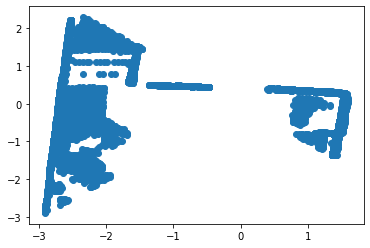

In [18]:
plt.scatter(points_transformed[:, 0], points_transformed[:, 1])

In [11]:
a = np.ones((100, 3))

In [12]:
a[[0, 2, 4], :]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [13]:
points_transformed.shape

(11398, 3)